# Week 5 Exercises: Statistics for Data Science

In [1]:
from scipy.stats import (chi2,
                         chi2_contingency,
                         pearsonr,
                         t,
                         ttest_ind)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Part 1: Differences in Means

1. In this question, we'll use the penguins dataset. Read this into a DataFrame named `penguins`. We're only going to focus on two of the species, adelie and chinstrap, so filter down to these two using the following code:
```
penguins = penguins[penguins['species'].isin(['Adelie', 'Chinstrap'])]
```

In [2]:
# IMPORT DATASET
penguins = pd.read_csv("../data/penguins.csv")

# Remove NaN
penguins = penguins[penguins['species'].isin(['Adelie', 'Chinstrap'])]
penguins = penguins.dropna(subset="body_mass_g")

a. Take a look at the distribution of body mass for these two species. What do you notice?

In [3]:
# VIEW DISTRIBUTION
penguins.groupby("species")['body_mass_g'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
Adelie,151.0,3700.662252,458.566126,2850.0,3350.0,3700.0,4000.0,4775.0
Chinstrap,68.0,3733.088235,384.335081,2700.0,3487.5,3700.0,3950.0,4800.0


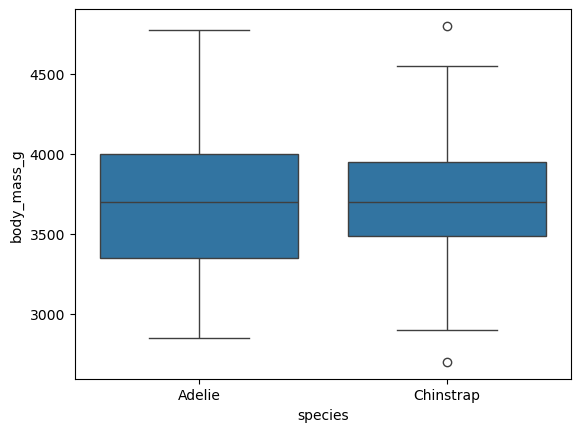

In [4]:
sns.boxplot(data=penguins, x="species", y="body_mass_g");

b. Test the hypothesis that the distribution of body masses is different for these two species. Do this by using the difference in means as your test statistic. What conclusion do you reach? Use the 0.05 significance level.

**Null Hypothesis:**

$H_0: \mu_A = \mu_C$

**Alternative Hypothesis:**

$H_1: \mu_A \neq \mu_C$

In [5]:
# PERMUTATION TESTING

# Get the difference in means as the test statistic
penguins_test_statistic = penguins.groupby("species")['body_mass_g'].mean().diff().abs().iloc[1]
print(f"OBSERVED DIFFERENCE IN MEANS: {penguins_test_statistic}")

OBSERVED DIFFERENCE IN MEANS: 32.42598363848856


P-VALUE: 0.6167


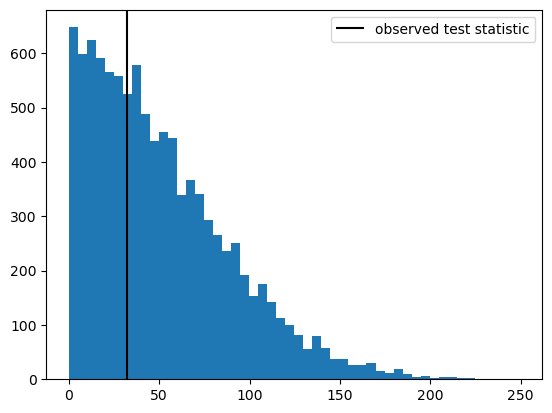

In [6]:
# Set number of permutations
num_permutations = 10000

# Create permutations
penguins_permutations = np.array([np.random.choice(penguins['body_mass_g'],
                                                   len(penguins['body_mass_g']),
                                                   replace=False)
                                  for i in range(num_permutations)])

# Get the number of Adelie observations
num_adelie = penguins['species'].value_counts()['Adelie']

# Get the Adelie permutation differences
penguins_permutations_diff = np.abs(penguins_permutations[:,:num_adelie].mean(axis=1) - penguins_permutations[:,num_adelie:].mean(axis=1))

# Plot the permutation difference
plt.hist(penguins_permutations_diff, bins=50)
ymin, ymax = plt.ylim()
plt.vlines(x=penguins_test_statistic,
           ymin=ymin,
           ymax=ymax,
           color='black',
           label='observed test statistic')
plt.ylim(ymin, ymax)
plt.legend();

# Calculate the p-value
print(f"P-VALUE: {(np.array(penguins_permutations_diff) >= penguins_test_statistic).mean()}")

**ANSWER: THERE IS A HIGH PROBABILITY THAT THE VALUES ARE INDEPENDENT. THEREFOR WE DO NOT REJECT THE NULL HYPOTHESIS.**

In [7]:
penguins_t_results = ttest_ind(penguins.loc[penguins['species'] == 'Adelie', 'body_mass_g'],
                               penguins.loc[penguins['species'] == 'Chinstrap', 'body_mass_g'],
                               equal_var=False,
                               alternative="two-sided")
penguins_t_results

TtestResult(statistic=np.float64(-0.5430902472363278), pvalue=np.float64(0.5878608159584937), df=np.float64(152.45479562284967))

c. Challenge question: Test whether there is a difference in the standard deviation of body mass between the two species. Hint: You'll need to run a permutation test for this. Use the difference in standard deviations as your test statistic. What conclusion do you reach now? Use the 0.05 significance level.

In [8]:
# PERMUTATION TESTING

# Get the difference in means as the test statistic
penguins_test_statistic = penguins.groupby("species")['body_mass_g'].std().diff().abs().iloc[1]
print(f"OBSERVED DIFFERENCE IN MEANS: {penguins_test_statistic}")

OBSERVED DIFFERENCE IN MEANS: 74.23104452294336


P-VALUE: 0.25947878525998996


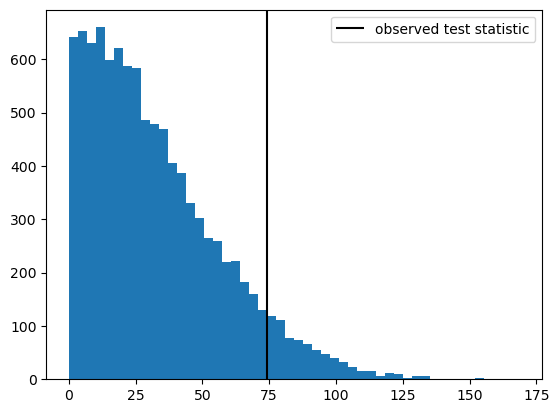

In [9]:
# Set number of permutations
num_permutations = 10000

# Create permutations
penguins_permutations = np.array([np.random.choice(penguins['body_mass_g'],
                                                   len(penguins['body_mass_g']),
                                                   replace=False)
                                  for i in range(num_permutations)])

# Get the number of Adelie observations
num_adelie = penguins['species'].value_counts()['Adelie']

# Get the Adelie permutation differences
penguins_permutations_diff = np.abs(penguins_permutations[:,:num_adelie].std(axis=1) - penguins_permutations[:,num_adelie:].std(axis=1))

# Plot the permutation difference
plt.hist(penguins_permutations_diff, bins=50)
ymin, ymax = plt.ylim()
plt.vlines(x=penguins_test_statistic,
           ymin=ymin,
           ymax=ymax,
           color='black',
           label='observed test statistic')
plt.ylim(ymin, ymax)
plt.legend();

# Calculate the p-value
print(f"P-VALUE: {(np.array(penguins_permutations_diff) >= penguins_test_statistic).std()}")

**ANSWER: A DIFFERENCE THIS SIZE IS EXPECTED MORE THAN THE SIGNIFICANCE LEVEL. THEREFORE, THE WE ACCEPT THE NULL HYPOTHESIS**

### Part 2: Tests for Dependence

1. In this question and the next, you'll be looking at shooting data from NBA games that took place during the 2014/2015 NBA season. We'll be working with data from one particular player, Steph Curry, who is widely regarded as one of the greatest shooters in NBA history. You have been provided a dataset, curry_shooting.csv, which contains all shots that Steph Curry took during the 2014/2015 NBA season. Read this dataset into a DataFrame named `shots`.

The SHOT_RESULT column indicates whether a particular shot was successful, and the PERIOD column shows which quarter (1-4) or overtime period (5) the shot took place. In this question, we'll explore whether the PERIOD and SHOT_RESULT columns are independent or dependent.

In [10]:
# IMPORT DATASET
shots = pd.read_csv("../data/curry_shooting.csv")

a. Create a cross-tabulation to look at Curry's makes/misses vs. game period. What do you notice?

In [11]:
# Remove NaN
period_shots = shots.dropna(subset=['PERIOD', 'SHOT_RESULT'])

# Create a cross-tabulation
shots_cross_tab = pd.crosstab(period_shots['SHOT_RESULT'], period_shots['PERIOD'])
shots_cross_tab

PERIOD,1,2,3,4,5
SHOT_RESULT,,,,,
made,164,87,134,81,4
missed,155,91,147,103,2


In [12]:
pd.crosstab(period_shots['SHOT_RESULT'], period_shots['PERIOD'], normalize="columns")

PERIOD,1,2,3,4,5
SHOT_RESULT,,,,,
made,0.514107,0.488764,0.476868,0.440217,0.666667
missed,0.485893,0.511236,0.523132,0.559783,0.333333


**SHOTS MADE IN THE 5TH PERIOD SEEM TO INCREASE**

b. Run a hypothesis test for whether Curry's makes/misses and game period are dependent.

**Null Hypothesis:**  
$H_0:$ Curry's made shots and the periods are **independent**.

**Alternative Hypothesis:**   
$H_1:$ Curry's made shots and the periods are **dependent**.

$$P(\text{Made Shots }= x\text{ and Period }= y) = P(\text{Made Shots }= x)\cdot P(\text{Period }= y).$$

In [13]:
# ESTIMATE INDEPENDENT PROBABILITIES
shots_ind_prob = np.outer(shots['SHOT_RESULT'].value_counts(normalize=True).sort_index(),
                          shots['PERIOD'].value_counts(normalize=True).sort_index())

shots_ind_prob_df = pd.DataFrame(shots_ind_prob,
                                 index=shots['SHOT_RESULT'].value_counts(normalize=True).sort_index().index,
                                 columns=shots['PERIOD'].value_counts(normalize=True).sort_index().index)

print("SHOTS INDEPENDENT PROBABILITY:")
shots_ind_prob_df

SHOTS INDEPENDENT PROBABILITY:


PERIOD,1,2,3,4,5
SHOT_RESULT,,,,,
made,0.160007,0.089283,0.140946,0.092292,0.003010
missed,0.169539,0.094602,0.149343,0.097790,0.003189


In [14]:
# CALCULATE TEST STATISTIC
shots_expected = shots_ind_prob_df * shots_cross_tab.sum().sum()
shots_expected

PERIOD,1,2,3,4,5
SHOT_RESULT,,,,,
made,154.886364,86.42562,136.43595,89.338843,2.913223
missed,164.113636,91.57438,144.56405,94.661157,3.086777


**chi-squared**

$$\chi^2 = \sum_{i,j} \frac{(observed_{i,j} - expected_{i,j})^2}{expected_{i,j}}$$

TEST STATISTIC: 16.370446324304304
P-VALUE: 0.002560309453786138 (THE P-VALS ARE DIFFERENT)


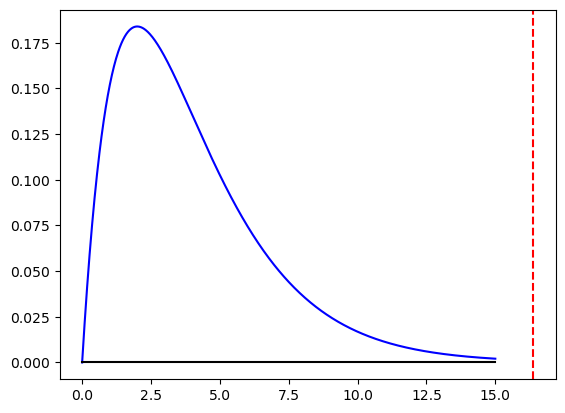

In [39]:
shots_test_stat = ((shots_cross_tab - shots_expected)**2 / shots_expected).sum().sum()
print(f"TEST STATISTIC: {shots_test_stat}")

shots_pval = chi2.sf(x=shots_test_stat, df=4)
print(f"P-VALUE: {shots_pval} (THE P-VALS ARE DIFFERENT)")

x = np.linspace(start=0, stop=15, num=1000)
plt.plot(
    x,
    chi2.pdf(x, df=4),
    color="blue"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=shots_test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [16]:
# CHI SQUARED DISTRIBUTION
chi2_contingency(shots_cross_tab)

Chi2ContingencyResult(statistic=np.float64(3.4352879934003133), pvalue=np.float64(0.4877859143811325), dof=4, expected_freq=array([[154.88636364,  86.42561983, 136.43595041,  89.33884298,
          2.91322314],
       [164.11363636,  91.57438017, 144.56404959,  94.66115702,
          3.08677686]]))

**ANSWER: THERE IS A HIGH PROBABILITY THAT THE VALUES ARE INDEPENDENT. THEREFOR WE DO NOT REJECT THE NULL HYPOTHESIS.**

c. In the NBA players can earn more points for a successful basket that is made from behind the 3-point line. The type of shot (2-pointer vs 3-pointer) is indicated by the PTS_TYPE column. Test whether PTS_TYPE and SHOT_RESULT are dependent for Steph Curry.

**Null Hypothesis:**  
$H_0:$ Curry's made shots and the points type are **independent**.

**Alternative Hypothesis:**   
$H_1:$ Curry's made shots and the points type are **dependent**.

$$P(\text{Made Shots }= x\text{ and Points Type }= y) = P(\text{Made Shots }= x)\cdot P(\text{Points Type }= y).$$

In [17]:
# Remove NaN
points_shots = shots.dropna(subset=['PTS_TYPE', 'SHOT_RESULT'])

# Create a cross-tabulation
shots_cross_tab = pd.crosstab(points_shots['SHOT_RESULT'], points_shots['PTS_TYPE'])
shots_cross_tab

PTS_TYPE,2,3
SHOT_RESULT,,
made,280,190
missed,232,266


In [18]:
pd.crosstab(points_shots['SHOT_RESULT'], points_shots['PTS_TYPE'], normalize="columns")

PTS_TYPE,2,3
SHOT_RESULT,,
made,0.546875,0.416667
missed,0.453125,0.583333


In [19]:
# ESTIMATE INDEPENDENT PROBABILITIES
shots_ind_prob = np.outer(shots['SHOT_RESULT'].value_counts(normalize=True).sort_index(),
                          shots['PTS_TYPE'].value_counts(normalize=True).sort_index())

shots_ind_prob_df = pd.DataFrame(shots_ind_prob,
                              index=shots['SHOT_RESULT'].value_counts(normalize=True).sort_index().index,
                              columns=shots['PTS_TYPE'].value_counts(normalize=True).sort_index().index)

print("SHOTS INDEPENDENT PROBABILITY:")
shots_ind_prob_df

SHOTS INDEPENDENT PROBABILITY:


PTS_TYPE,2,3
SHOT_RESULT,,
made,0.256813,0.228724
missed,0.272113,0.242350


In [20]:
# CALCULATE TEST STATISTIC
shots_expected = shots_ind_prob_df * shots_cross_tab.sum().sum()
shots_expected

PTS_TYPE,2,3
SHOT_RESULT,,
made,248.595041,221.404959
missed,263.404959,234.595041


TEST STATISTIC: 16.370446324304304
P-VALUE: 5.2091153223847753e-05 (THE P-VALS ARE DIFFERENT)


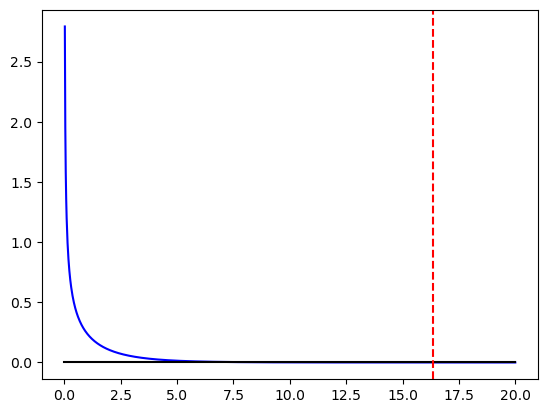

In [40]:
shots_test_stat = ((shots_cross_tab - shots_expected)**2 / shots_expected).sum().sum()
print(f"TEST STATISTIC: {shots_test_stat}")

shots_pval = chi2.sf(x=shots_test_stat, df=1)
print(f"P-VALUE: {shots_pval} (THE P-VALS ARE DIFFERENT)")

x = np.linspace(start=0, stop=20, num=1000)
plt.plot(
    x,
    chi2.pdf(x, df=1),
    color="blue"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=shots_test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [22]:
# CHI SQUARED DISTRIBUTION
chi2_contingency(shots_cross_tab)

Chi2ContingencyResult(statistic=np.float64(15.8533264286148), pvalue=np.float64(6.844611447259658e-05), dof=1, expected_freq=array([[248.59504132, 221.40495868],
       [263.40495868, 234.59504132]]))

**ANSWER: THERE IS A LOW PROBABILITY THAT THE VALUES ARE INDEPENDENT. THEREFOR WE REJECT THE NULL HYPOTHESIS.**

2. In the week 3 exercises, we examined the relationship between rain_today, rain_yesterday, and day_of week. Now, let's perform hypothesis tests to see if the observed dependence we saw holds up to a statistical test. Read in the data from bna_rain.csv into a DataFrame named bna_rain.

In [23]:
bna_rain = pd.read_csv("../data/bna_rain.csv")

a. Test whether rained_today and rained_yesterday are dependent.

**Null Hypothesis:**  
$H_0:$ Rained today and rained yesterday are **independent**.

**Alternative Hypothesis:**   
$H_1:$ Rained today and rained yesterday are **dependent**.

$$P(\text{Rained Today }= x\text{ and Rained Yesterday }= y) = P(\text{Rained Today }= x)\cdot P(\text{Rained Yesterday }= y).$$

In [24]:
# Remove NaN
today_yesterday = bna_rain.dropna(subset=['rained_today', 'rained_yesterday'])

# Create a cross-tabulation
today_yesterday_ct = pd.crosstab(today_yesterday['rained_today'], today_yesterday['rained_yesterday'])
today_yesterday_ct

rained_yesterday,False,True
rained_today,,
False,189,60
True,60,56


In [25]:
# ESTIMATE INDEPENDENT PROBABILITIES
rained_ind_prob = np.outer(today_yesterday['rained_today'].value_counts(normalize=True).sort_index(),
                           today_yesterday['rained_yesterday'].value_counts(normalize=True).sort_index())

rained_ind_prob_df = pd.DataFrame(rained_ind_prob,
                                  index=today_yesterday['rained_today'].value_counts(normalize=True).sort_index().index,
                                  columns=today_yesterday['rained_yesterday'].value_counts(normalize=True).sort_index().index)

print("RAINED INDEPENDENT PROBABILITY:")
rained_ind_prob_df

RAINED INDEPENDENT PROBABILITY:


rained_yesterday,False,True
rained_today,,
False,0.465386,0.216806
True,0.216806,0.101002


In [26]:
# CALCULATE TEST STATISTIC
rained_expected = rained_ind_prob_df * today_yesterday_ct.sum().sum()
rained_expected

rained_yesterday,False,True
rained_today,,
False,169.865753,79.134247
True,79.134247,36.865753


TEST STATISTIC: 0.0
P-VALUE: 1.0 (THE P-VALS ARE DIFFERENT)


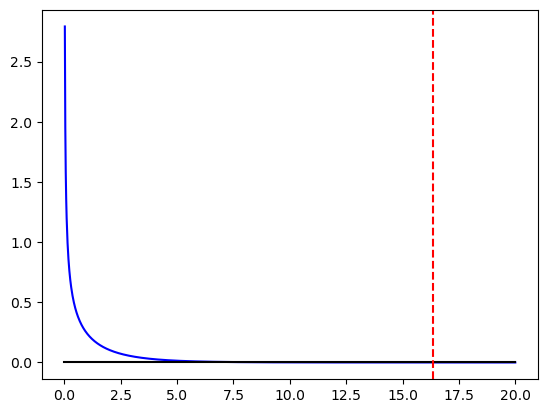

In [41]:
rained_test_stat = ((today_yesterday_ct - rained_expected)**2 / rained_expected).sum().sum()
print(f"TEST STATISTIC: {rained_test_stat}")

rained_pval = chi2.sf(x=rained_test_stat, df=1)
print(f"P-VALUE: {rained_pval} (THE P-VALS ARE DIFFERENT)")

x = np.linspace(start=0, stop=20, num=1000)
plt.plot(
    x,
    chi2.pdf(x, df=1),
    color="blue"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=shots_test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [28]:
# CHI SQUARED DISTRIBUTION
chi2_contingency(today_yesterday_ct)

Chi2ContingencyResult(statistic=np.float64(20.238932250126624), pvalue=np.float64(6.834772627945469e-06), dof=1, expected_freq=array([[169.86575342,  79.13424658],
       [ 79.13424658,  36.86575342]]))

**ANSWER: THERE IS A LOW PROBABILITY THAT THmE VALUES ARE INDEPENDENT. THEREFOR WE REJECT THE NULL HYPOTHESIS.**

b. Test whether rained_today and day_of_week are dependent.

**Null Hypothesis:**  
$H_0:$ Rained today and day of the week are **independent**.

**Alternative Hypothesis:**   
$H_1:$ Rained today and day of the week are **dependent**.

$$P(\text{Rained Today }= x\text{ and Day of the Week }= y) = P(\text{Rained Today }= x)\cdot P(\text{Day of the Week }= y).$$

In [29]:
# Remove NaN
today_dow = bna_rain.dropna(subset=['rained_today', 'day_of_week'])

# Create a cross-tabulation
today_dow_ct = pd.crosstab(today_dow['rained_today'], today_dow['day_of_week'])
today_dow_ct

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
rained_today,,,,,,,
False,36,36,33,38,33,39,34
True,16,16,20,14,19,13,18


In [30]:
# ESTIMATE INDEPENDENT PROBABILITIES
rained_ind_prob = np.outer(today_dow['rained_today'].value_counts(normalize=True).sort_index(),
                           today_dow['day_of_week'].value_counts(normalize=True).sort_index())

rained_ind_prob_df = pd.DataFrame(rained_ind_prob,
                                  index=today_dow['rained_today'].value_counts(normalize=True).sort_index().index,
                                  columns=today_dow['day_of_week'].value_counts(normalize=True).sort_index().index)

print("RAINED INDEPENDENT PROBABILITY:")
rained_ind_prob_df

RAINED INDEPENDENT PROBABILITY:


day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
rained_today,,,,,,,
False,0.097189,0.097189,0.099058,0.097189,0.097189,0.097189,0.097189
True,0.045277,0.045277,0.046147,0.045277,0.045277,0.045277,0.045277


In [31]:
# CALCULATE TEST STATISTIC
rained_expected = rained_ind_prob_df * today_dow_ct.sum().sum()
rained_expected

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
rained_today,,,,,,,
False,35.473973,35.473973,36.156164,35.473973,35.473973,35.473973,35.473973
True,16.526027,16.526027,16.843836,16.526027,16.526027,16.526027,16.526027


TEST STATISTIC: 3.3203758681188895
P-VALUE: 0.7676939391657143


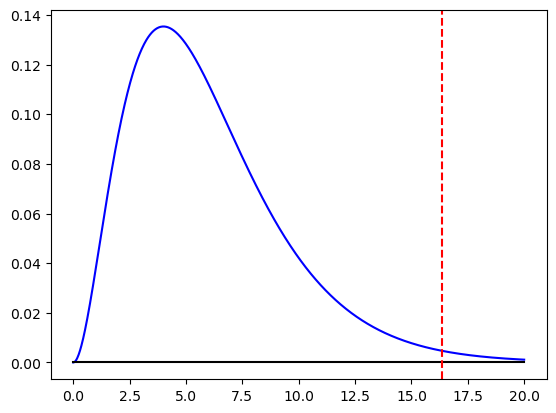

In [32]:
rained_test_stat = ((today_dow_ct - rained_expected)**2 / rained_expected).sum().sum()
print(f"TEST STATISTIC: {rained_test_stat}")

rained_pval = chi2.sf(x=rained_test_stat, df=6)
print(f"P-VALUE: {rained_pval}")

x = np.linspace(start=0, stop=20, num=1000)
plt.plot(
    x,
    chi2.pdf(x, df=6),
    color="blue"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=shots_test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [33]:
# CHI SQUARED DISTRIBUTION
chi2_contingency(today_dow_ct)

Chi2ContingencyResult(statistic=np.float64(3.32037586811889), pvalue=np.float64(0.7676939391657143), dof=6, expected_freq=array([[35.4739726 , 35.4739726 , 36.15616438, 35.4739726 , 35.4739726 ,
        35.4739726 , 35.4739726 ],
       [16.5260274 , 16.5260274 , 16.84383562, 16.5260274 , 16.5260274 ,
        16.5260274 , 16.5260274 ]]))

**ANSWER: THERE IS A HIGH PROBABILITY THAT THE VALUES ARE INDEPENDENT. THEREFOR WE DO NOT REJECT THE NULL HYPOTHESIS.**

### Part 3: Test for Correlation
Read in the file shifted_BNA_temps.csv into a DataFrame named bna. 

In [34]:
bna = pd.read_csv("../data/shifted_BNA_temps.csv")

1. In week 2, we saw that there was a moderate positive correlation between TMAX and TMAX_LY. Run a hypothesis test to see if this correlation is statistically significant.

**Null Hypothesis:**  
$H_0:$ There is zero correlation between TMAX and TMAX_LY.

**Alternative Hypothesis:**   
$H_1:$ There is a non-zero correlation between TMAX and TMAX_LY.

CORRELATION: 0.7054046426203079
PERMUTAION CORRELATIONS: 0.0
PearsonRResult(statistic=np.float64(0.7054046426203079), pvalue=np.float64(1.0257e-320))


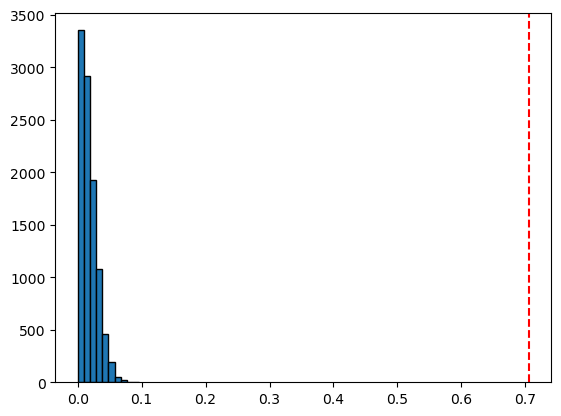

In [38]:
# REMOVE NaN
bna_tmax_ly = bna.dropna(subset=['TMAX', 'TMAX_LY'])

# PERMUTATION METHOD
# Get the correlation
r = bna[['TMAX', 'TMAX_LY']].corr().iloc[0,1]
print(f"CORRELATION: {r}")

# Create permutations of TMAX
num_permutations = 10000

permutations = np.array([np.random.choice(bna_tmax_ly['TMAX_LY'],
                                          len(bna_tmax_ly['TMAX_LY']),
                                          replace=False)
                         for i in range(num_permutations)])

# Calculate the permutation correlations
permutation_correlations = np.abs(np.corrcoef(bna_tmax_ly['TMAX'], permutations)[0, 1:])

print(f"PERMUTAION CORRELATIONS: {(permutation_correlations >= np.abs(r)).mean()}")

plt.hist(permutation_correlations,
         edgecolor="black")

ymin, ymax = plt.ylim()
plt.vlines(x=abs(r),
           ymin=ymin,
           ymax=ymax,
           color="red",
           linestyle="--")
plt.ylim(ymin, ymax);

print(pearsonr(x=bna['TMAX'], y=bna['TMAX_LY']))

**ANSWER: BASED ON THIS P-VALUE, WE CAN CONCLUDE THAT THERE IS A NON-ZERO CORRELATION.**

2. In week 2, we saw that there was a very small positive correlation between TMAX and TMAX_3MO. Run a hypothesis test to see if this correlation is statistically significant.

**Null Hypothesis:**  
$H_0:$ There is zero correlation between TMAX and TMAX_3MO.

**Alternative Hypothesis:**   
$H_1:$ There is a non-zero correlation between TMAX and TMAX_3MO.

$$t = \frac{r\cdot\sqrt{n-2}}{\sqrt{1-r^2}}$$

CORRELATION: 0.001908656322639645
SHAPE: 2132
OBSERVED T: 0.08808832015793006
1.0701852398813045
PearsonRResult(statistic=np.float64(0.0019086563226388166), pvalue=np.float64(0.9298147601187198))


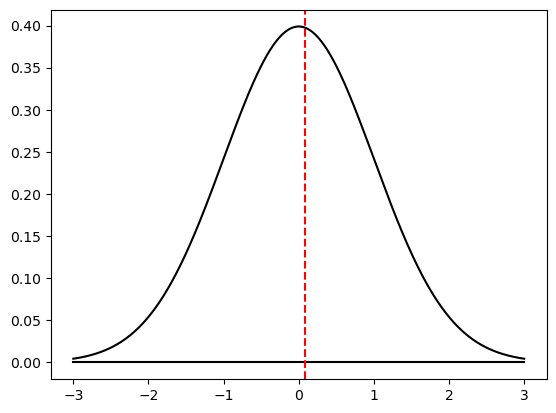

In [36]:
# REMOVE NaN
bna_tmax_3mo = bna.dropna(subset=['TMAX', 'TMAX_3MO'])

# T-DISTRIBUTION METHOD
r = bna_tmax_3mo[['TMAX', 'TMAX_3MO']].corr().iloc[0,1]
n = bna_tmax_3mo.shape[0]
print(f"CORRELATION: {r}")
print(f"SHAPE: {n}")

# Calculate observed t-distribution
observed_t = r * np.sqrt(n-2) / np.sqrt(1 - r**2)
print(f"OBSERVED T: {observed_t}")

x = np.linspace(start=-3, stop=3, num=1000)
plt.plot(x,
         t.pdf(x,
               df=n-2),
         color="black")
plt.plot(x,
         np.zeros_like(x),
         color="black")
ymin,ymax = plt.ylim()
plt.vlines(x=observed_t,
           ymin=ymin,
           ymax=ymax,
           color="red",
           linestyle="--")
plt.ylim(ymin, ymax);

print(2*t.cdf(observed_t, df=n-2))

print(pearsonr(x=bna_tmax_3mo['TMAX'], y=bna_tmax_3mo['TMAX_3MO']))

**ANSWER: BASED ON THIS P-VALUE, WE CAN CONCLUDE THAT THERE IS ZERO CORRELATION.**